# FESDModel - Model Evaluation

FESD - Fault estimation for skeleton detection - is a suite that aims at finding faults in joints of skeletons, which are detected by human pose estimatiors.

FESDData is the sister project to this notebook, which aims at recording depth and rgb data, as well as populating the data with human poses from variing human pose estimators.

Furthermore, FESTData augments all data based on joint confidence.

FFESDModel aims to develop and evaluate a model based on the faulty and augmented joint data as well as RGBD data.

## Libraries

We need a range of libraries which are imported here. We also define some constants.

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
from pathlib import Path
from time import time

from data import FESDDataset
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set()

import cv2

from model import FESD, train, val, test
import copy

import scipy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datetime

import torch

from utils.mode import Mode
from utils import err2gt, gt2err

from tqdm.notebook import tqdm

In [3]:
RECORDING_DIR = Path('D:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

## Metadata Loading

Firstly we need to import all the recordings into the notebook.


In [4]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

13

In [8]:
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

body_halves = np.array(["Upper Half", "Lower Half"])
limbs = np.array(["Head", "Torso", "Left arm", "Right arm", "Left leg", "Right leg"])

upper_body_i = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
lower_body_i = [3, 14, 15, 16, 17, 18, 19]

torso_i     = [2, 3, 4, 9]
head_i      = [0, 1]
left_arm_i  = [5, 6, 7, 8]
right_arm_i = [10, 11, 12, 13]
left_leg_i  = [14, 15, 16]
right_leg_i = [17, 18, 19]

joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

## Model Evaluation

Here we create all graphs and analysis for the training

In [9]:
# Load the results of training and testing

df_model = pd.read_parquet('ModelAnalysis.parquet.gzip')
df_model["difficulty"] = df_model.apply(lambda x: int(x["exercise"][2]), axis=1)
df_model["mode"] = df_model["mode"].apply(lambda x: Mode.from_str(mode_str=x))
print(df_model.columns)

Index(['epoch', 'iteration', 'joint_id', 'gts', 'preds', 'confidences',
       'Avg loss', 'loss', 'accuracy', 'tp', 'tn', 'fp', 'fn', 'precision',
       'recall', 'f1', 'cohens_kappa', 'learning_rate', 'train_test',
       'exercise', 'simplified', 'mode', 'use_v2', 'difficulty'],
      dtype='object')


In [10]:
df_model["p"] = df_model["tp"] + df_model["fp"]
df_model["n"] = df_model["tn"] + df_model["fn"]
df_model["p/(p+n)"] = df_model["p"] / (df_model["n"] + df_model["p"])

In [11]:
coi = ["difficulty", "p/(p+n)", "accuracy", "precision", "recall", "f1", "cohens_kappa"]
coi_tf_pn = ["tp", "tn", "fp", "fn", "p", "n"]

### Training Evaluation

In [12]:
df_model_train = df_model[df_model["train_test"] == "train"]

#### Full Body Model

In [13]:
df_model_train_fb = df_model_train[df_model_train["mode"] == Mode.FULL_BODY]

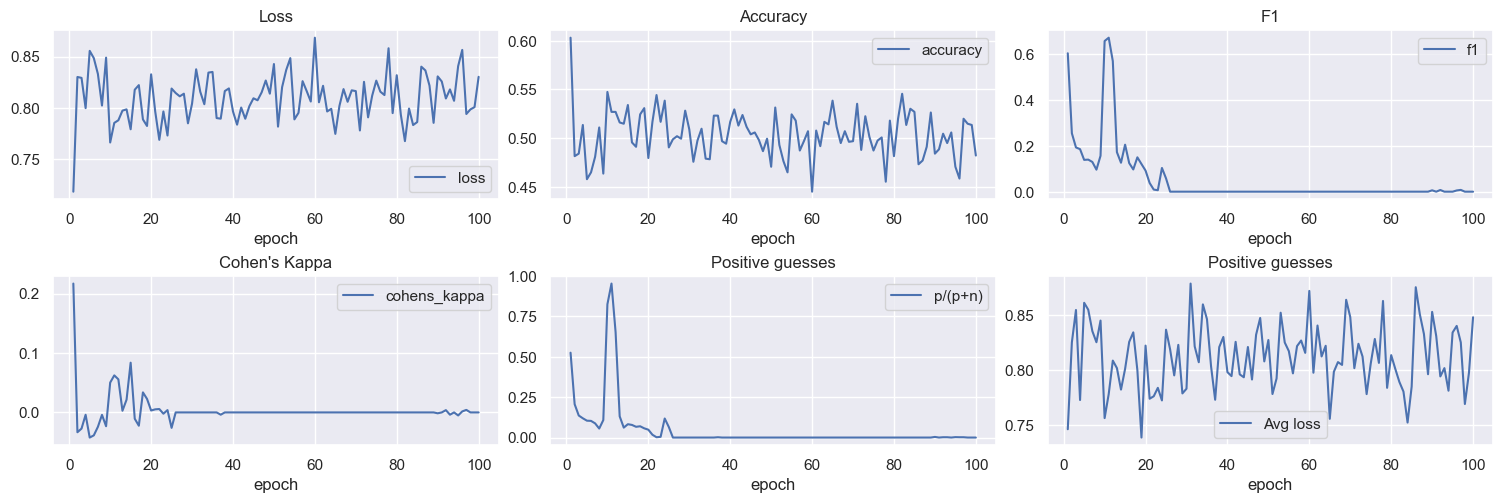

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=3)

df_model_train_fb[["epoch", "loss"]].groupby("epoch").mean().plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0])
df_model_train_fb[["epoch", "accuracy"]].groupby("epoch").mean().plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
df_model_train_fb[["epoch", "f1"]].groupby("epoch").mean().plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
df_model_train_fb[["epoch", "cohens_kappa"]].groupby("epoch").mean().plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
df_model_train_fb[["epoch", "p/(p+n)"]].groupby("epoch").mean().plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])
df_model_train_fb[["epoch", "Avg loss"]].groupby("epoch").mean().plot(y="Avg loss" , figsize=(15, 5), title="Positive guesses", ax=axs[1][2])
fig.tight_layout(pad=.5)
plt.show()

#### Half Body

In [15]:
df_model_train_hb = df_model_train[df_model_train["mode"] == Mode.HALF_BODY]
df_model_train_hb["joint"] = df_model_train_hb["joint_id"].apply(lambda x: body_halves[x])

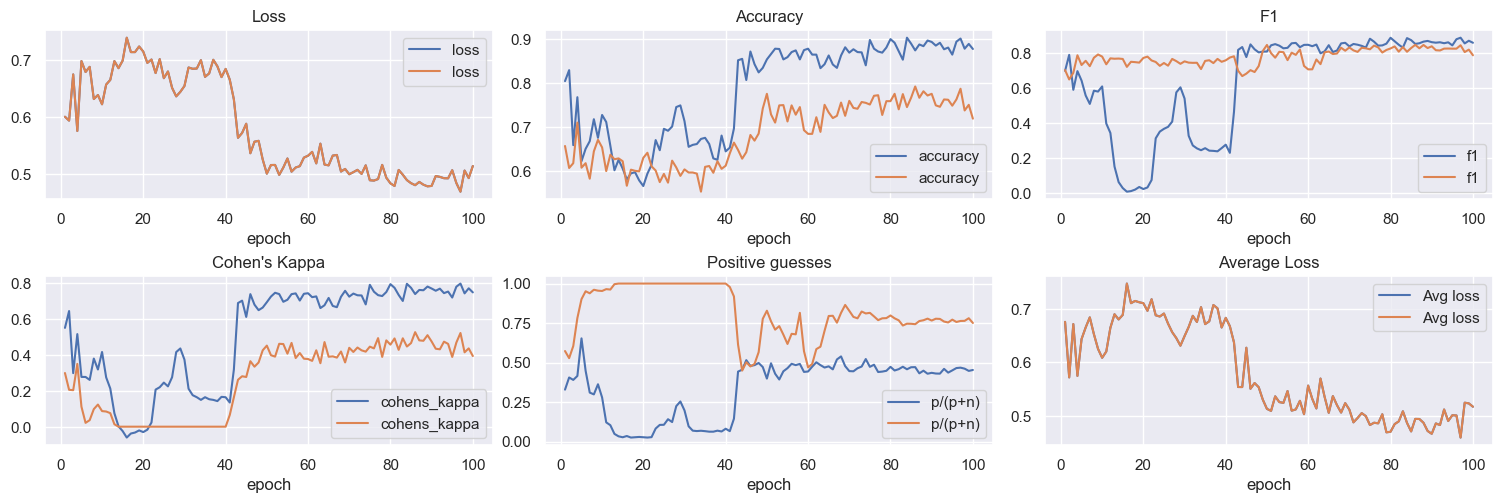

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=3)

vals_lh = df_model_train_hb[df_model_train_hb["joint"] == "Lower Half"]
vals_uh = df_model_train_hb[df_model_train_hb["joint"] == "Upper Half"]

def plot(df, axs):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0])
  df.plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
  df.plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
  df.plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
  df.plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])
  df.plot(y="Avg loss" , figsize=(15, 5), title="Average Loss", ax=axs[1][2])

plot(vals_lh, axs)
plot(vals_uh, axs)

fig.tight_layout(pad=.5)
plt.show()

#### Limbs

How to improve models
- implement balanced batching
- better cost/loss function
2. use single error
1. use inception network for RGB and depth
- Confusion matrix

R: RGB -> Grey
G: Depth
B: Black and white joints
Make 4 pictures of one example

In [17]:
df_model_train_lb = df_model_train[df_model_train["mode"] == Mode.LIMBS]
df_model_train_lb["joint"] = df_model_train_lb["joint_id"].apply(lambda x: limbs[x])

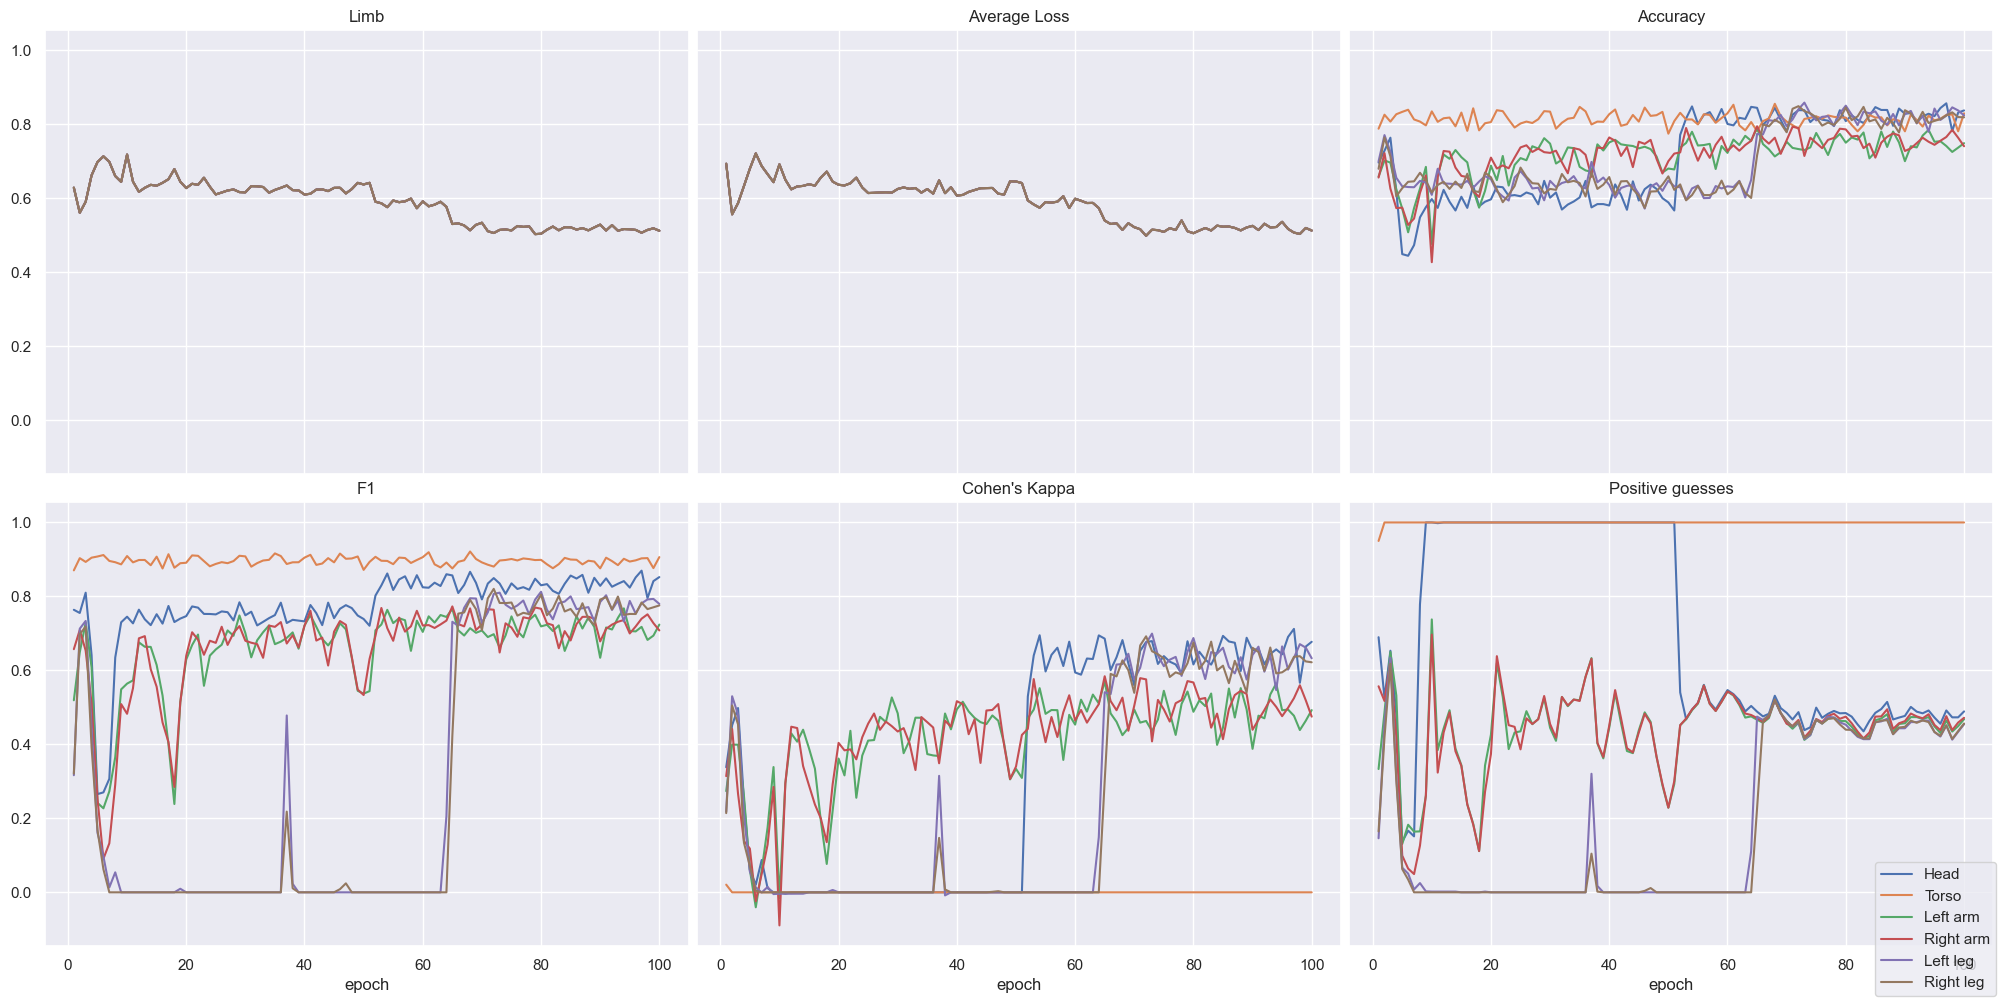

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20, 10))

def plot(df, axs, limb):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss",         title="Limb", ax=axs[0][0], legend=False)
  df.plot(y="Avg loss" ,    title="Average Loss", ax=axs[0][1], legend=False)

  df.plot(y="accuracy",     title="Accuracy", ax=axs[0][2], legend=False)
  df.plot(y="f1",           title="F1", ax=axs[1][0], legend=False)
  df.plot(y="cohens_kappa", title="Cohen's Kappa", ax=axs[1][1], legend=False)
  df.plot(y="p/(p+n)" ,     title="Positive guesses", ax=axs[1][2], legend=False)

for limb in limbs:
  df = df_model_train_lb[df_model_train_lb["joint"] == limb]
  plot(df, axs, limb)
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, limbs, loc='lower right')
fig.tight_layout(pad=.5)
plt.show()

#### Joints

In [19]:
df_model_train_jt = df_model_train[df_model_train["mode"] == Mode.JOINTS]
df_model_train_jt["joint"] = df_model_train_jt["joint_id"].apply(lambda x: joint_names[x])

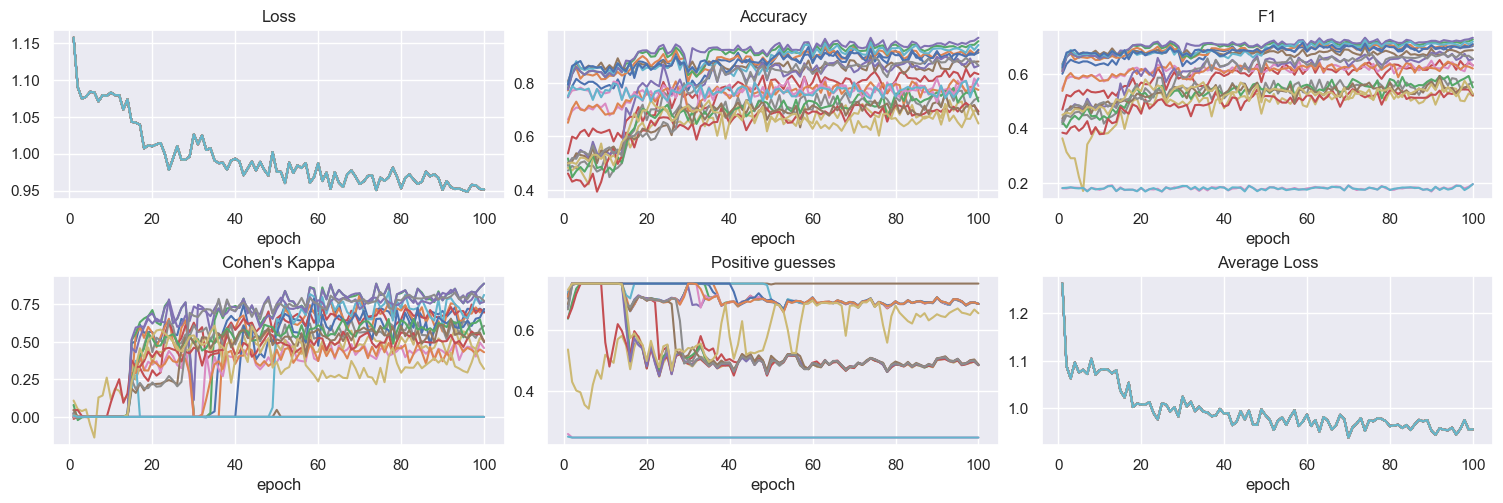

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=3)

def plot(df, axs):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0], legend=False)
  df.plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1], legend=False)
  df.plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2], legend=False)
  df.plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0], legend=False)
  df.plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1], legend=False)
  df.plot(y="Avg loss" , figsize=(15, 5), title="Average Loss", ax=axs[1][2], legend=False)


for joint in joint_names:
  df = df_model_train_jt[df_model_train_jt["joint"] == joint]
  plot(df, axs)

# axs[0][0].legend(joint_names)
fig.tight_layout(pad=.5)
plt.show()

### Test Evaluation

#### Full Body Evaluation

The evaluation of the whole body as an error boolean.

In [21]:
df_model_full_body = df_model[df_model["mode"] == Mode.FULL_BODY]
df_model_full_body_test = df_model_full_body[df_model_full_body["train_test"] == "test"]

In [22]:
df_model_full_body_test[coi].groupby(["difficulty"]).mean().sort_values(by="difficulty", ascending=False)

,p/(p+n),accuracy,precision,recall,f1,cohens_kappa
difficulty,,,,,,
3,0.0,0.883333,0.0,0.0,0.0,0.0
2,0.0,0.516667,0.0,0.0,0.0,0.0
1,0.0,0.083333,0.0,0.0,0.0,0.0
0,0.0,0.000000,0.0,0.0,0.0,0.0


In [23]:
df_model_full_body_test[coi_tf_pn + ["difficulty"]].groupby(["difficulty"]).sum()

,tp,tn,fp,fn,p,n
difficulty,,,,,,
0,0.0,0.0,0.0,90.0,0.0,90.0
1,0.0,5.0,0.0,55.0,0.0,60.0
2,0.0,31.0,0.0,29.0,0.0,60.0
3,0.0,53.0,0.0,7.0,0.0,60.0


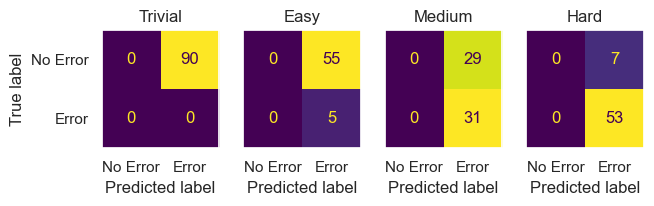

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(7, 2.5), sharey=True)
difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for difficulty in [0, 1, 2, 3]:
  gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_full_body_test[df_model_full_body_test["difficulty"] == difficulty]["gts"].values.tolist()]
  preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_full_body_test[df_model_full_body_test["difficulty"] == difficulty]["preds"].values.tolist()]
  cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
  disp.plot(ax=axs[difficulty], colorbar=False)
  axs[difficulty].set_title(difficulty_names[difficulty])
  axs[difficulty].grid(False)
  if difficulty != 0:
    axs[difficulty].set_ylabel("")


plt.savefig("figures/confusion/full.png")
plt.show()

#### Half Body Evaluation

The evaluation of the body split into two parts (upper and lower body), each as an error boolean.

In [25]:
# Split the data

df_model_half_body = df_model[df_model["mode"] == Mode.HALF_BODY]
df_model_half_body["joint_names"] = df_model_half_body["joint_id"].apply(lambda x: body_halves[x])
df_model_half_body_test = df_model_half_body[df_model_half_body["train_test"] == "test"]

In [26]:
df_model_half_body_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall        f1  \
joint_names difficulty                                                      
Lower Half  0           0.000000  0.466667   0.000000  0.000000  0.000000   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           0.000000  0.983333   0.000000  0.000000  0.000000   
            3           0.000000  1.000000   0.000000  0.000000  0.000000   
Upper Half  0           0.822222  0.822222   0.822222  0.822222  0.822222   
            1           1.000000  0.516667   0.516667  0.516667  0.516667   
            2           0.850000  0.550000   0.450000  0.450000  0.450000   
            3           0.000000  0.866667   0.000000  0.000000  0.000000   

                        cohens_kappa  
joint_names difficulty                
Lower Half  0                    0.0  
            1                    NaN  
            2                    0.0  
            3                    NaN  
Upper Half  0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0

In [27]:
df_model_half_body_test[coi_tf_pn + ["joint_names", "difficulty"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp    fn     p     n
joint_names difficulty                                    
Lower Half  0            0.0  42.0   0.0  48.0   0.0  90.0
            1           60.0   0.0   0.0   0.0  60.0   0.0
            2            0.0  59.0   0.0   1.0   0.0  60.0
            3            0.0  60.0   0.0   0.0   0.0  60.0
Upper Half  0           74.0   0.0   0.0  16.0  74.0  16.0
            1           31.0   0.0  29.0   0.0  60.0   0.0
            2           27.0   6.0  24.0   3.0  51.0   9.0
            3            0.0  52.0   0.0   8.0   0.0  60.0

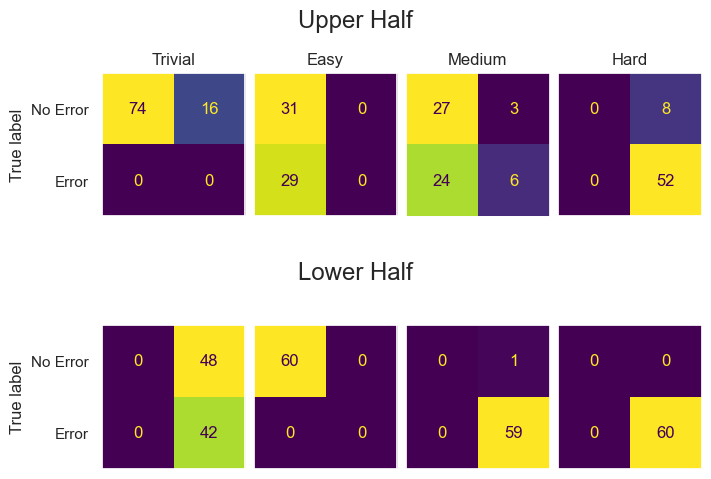

In [28]:
figure = plt.figure(layout='constrained', figsize=(7, 2.5 * len(body_halves)))
subfigs = figure.subfigures(2, 1)

difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for i, half in enumerate(body_halves):
  axs = subfigs[i].subplots(1, 4, sharey=True)
  subfigs[i].suptitle(half, fontsize='x-large')
  for difficulty in [0, 1, 2, 3]:  
    crit_1 = df_model_half_body_test["difficulty"] == difficulty
    crit_2 = df_model_half_body_test["joint_names"] == half
    crit = crit_1 & crit_2
    gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_half_body_test[crit]["gts"].values.tolist()]
    preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_half_body_test[crit]["preds"].values.tolist()]

    cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
    disp.plot(ax=axs[difficulty], colorbar=False)

    axs[difficulty].grid(False)
    if i == 0:
      axs[difficulty].set_title(difficulty_names[difficulty])
    if i < len(limbs) - 1:
      axs[difficulty].set_xlabel("") 
      axs[difficulty].set_xticks([]) 
    if difficulty != 0:
      axs[difficulty].set_ylabel("")

#plt.tight_layout()
plt.savefig("figures/confusion/halves.png")
plt.show()

#### Limb Evaluation

The evaluation of the body split into limbs (Head, Torso, Left and Right Arm, and Left and Right Leg), each as an error boolean.

In [29]:
# Split the data

df_model_limbs = df_model[df_model["mode"] == Mode.LIMBS]
df_model_limbs["joint_names"] = df_model_limbs["joint_id"].apply(lambda x: limbs[x])
df_model_limbs_test = df_model_limbs[df_model_limbs["train_test"] == "test"]

In [30]:
df_model_limbs_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall        f1  \
joint_names difficulty                                                      
Head        0           0.555556  0.555556   0.555556  0.555556  0.555556   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           0.983333  0.966667   0.966667  0.966667  0.966667   
            3           0.000000  0.766667   0.000000  0.000000  0.000000   
Left arm    0           0.400000  0.400000   0.400000  0.400000  0.400000   
            1           1.000000  0.566667   0.566667  0.566667  0.566667   
            2           0.966667  0.533333   0.516667  0.516667  0.516667   
            3           0.000000  0.783333   0.000000  0.000000  0.000000   
Left leg    0           0.355556  0.355556   0.355556  0.355556  0.355556   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           0.933333  0.883333   0.883333  0.883333  0.883333   
            3           0.000000  0.850000   0.000000  0.000000  0.000000   
Right arm   0           0.433333  0.433333   0.433333  0.433333  0.433333   
            1           1.000000  0.916667   0.916667  0.916667  0.916667   
            2           0.983333  0.833333   0.833333  0.833333  0.833333   
            3           0.000000  0.683333   0.000000  0.000000  0.000000   
Right leg   0           0.355556  0.355556   0.355556  0.355556  0.355556   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           0.933333  0.916667   0.916667  0.916667  0.916667   
            3           0.000000  0.750000   0.000000  0.000000  0.000000   
Torso       0           1.000000  1.000000   1.000000  1.000000  1.000000   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           1.000000  0.983333   0.983333  0.983333  0.983333   
            3           1.000000  0.383333   0.383333  0.383333  0.383333   

                        cohens_kappa  
joint_names difficulty                
Head        0                    0.0  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Left arm    0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Left leg    0                    0.0  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Right arm   0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Right leg   0                    0.0  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Torso       0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0

In [31]:
df_model_limbs_test[coi_tf_pn + ["joint_names", "difficulty"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp    fn     p     n
joint_names difficulty                                    
Head        0           50.0   0.0   0.0  40.0  50.0  40.0
            1           60.0   0.0   0.0   0.0  60.0   0.0
            2           58.0   0.0   1.0   1.0  59.0   1.0
            3            0.0  46.0   0.0  14.0   0.0  60.0
Left arm    0           36.0   0.0   0.0  54.0  36.0  54.0
            1           34.0   0.0  26.0   0.0  60.0   0.0
            2           31.0   1.0  27.0   1.0  58.0   2.0
            3            0.0  47.0   0.0  13.0   0.0  60.0
Left leg    0           32.0   0.0   0.0  58.0  32.0  58.0
            1           60.0   0.0   0.0   0.0  60.0   0.0
            2           53.0   0.0   3.0   4.0  56.0   4.0
            3            0.0  51.0   0.0   9.0   0.0  60.0
Right arm   0           39.0   0.0   0.0  51.0  39.0  51.0
            1           55.0   0.0   5.0   0.0  60.0   0.0
            2           50.0   0.0   9.0   1.0  59.0   1.0
            3            0.0  41.0   0.0  19.0   0.0  60.0
Right leg   0           32.0   0.0   0.0  58.0  32.0  58.0
            1           60.0   0.0   0.0   0.0  60.0   0.0
            2           55.0   0.0   1.0   4.0  56.0   4.0
            3            0.0  45.0   0.0  15.0   0.0  60.0
Torso       0           90.0   0.0   0.0   0.0  90.0   0.0
            1           60.0   0.0   0.0   0.0  60.0   0.0
            2           59.0   0.0   1.0   0.0  60.0   0.0
            3           23.0   0.0  37.0   0.0  60.0   0.0

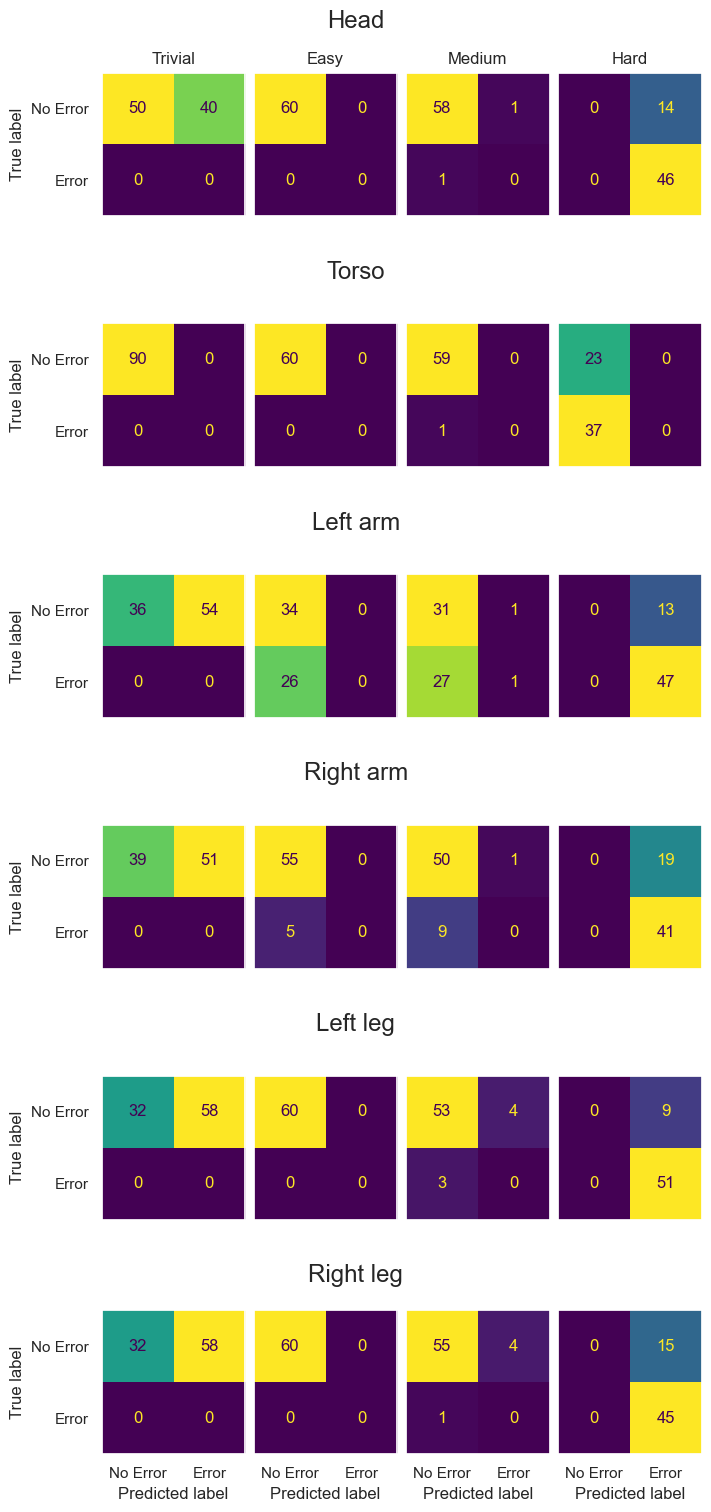

In [32]:
figure = plt.figure(layout='constrained', figsize=(7, 2.5 * len(limbs)))
subfigs = figure.subfigures(len(limbs), 1)

difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for i, limb in enumerate(limbs):
  axs = subfigs[i].subplots(1, 4, sharey=True)
  subfigs[i].suptitle(limb, fontsize='x-large')
  for difficulty in [0, 1, 2, 3]:  
    crit_1 = df_model_limbs_test["difficulty"] == difficulty
    crit_2 = df_model_limbs_test["joint_names"] == limb
    crit = crit_1 & crit_2
    gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_limbs_test[crit]["gts"].values.tolist()]
    preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_limbs_test[crit]["preds"].values.tolist()]

    cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
    disp.plot(ax=axs[difficulty], colorbar=False)

    axs[difficulty].grid(False)
    if i == 0:
      axs[difficulty].set_title(difficulty_names[difficulty])
    if i < len(limbs) - 1:
      axs[difficulty].set_xlabel("") 
      axs[difficulty].set_xticks([]) 
    if difficulty != 0:
      axs[difficulty].set_ylabel("")

#plt.tight_layout()
plt.savefig("figures/confusion/limbs.png")
plt.show()

#### Joint Evaluation

The evaluation of the body as an error class.

In [33]:
# Split the data

df_model_joints = df_model[df_model["mode"] == Mode.JOINTS]
df_model_joints["joint_names"] = df_model_joints["joint_id"].apply(lambda x: joint_names[x])
df_model_joints_test = df_model_joints[df_model_joints["train_test"] == "test"]

In [34]:
df_model_joints_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall        f1  \
joint_names difficulty                                                      
Head        0           0.750000  1.000000   1.000000  1.000000  0.750000   
            1           0.750000  1.000000   1.000000  1.000000  0.750000   
            2           0.750000  0.983333   0.983333  0.983333  0.737500   
            3           0.716667  0.533333   0.500000  0.500000  0.366667   
Left ankle  0           0.250000  0.411111   0.166667  0.166667  0.083333   
...                          ...       ...        ...       ...       ...   
Torso       3           0.716667  0.566667   0.533333  0.533333  0.400000   
Waist       0           0.750000  1.000000   1.000000  1.000000  0.750000   
            1           0.750000  1.000000   1.000000  1.000000  0.750000   
            2           0.750000  0.983333   0.983333  0.983333  0.737500   
            3           0.391667  0.683333   0.391667  0.391667  0.229167   

                        cohens_kappa  
joint_names difficulty                
Head        0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Left ankle  0                    0.0  
...                              ...  
Torso       3                    0.0  
Waist       0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  

[80 rows x 6 columns]

In [35]:
df_model_joints_test[coi_tf_pn + ["difficulty", "joint_names"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp     fn      p      n
joint_names difficulty                                        
Head        0           180.0  90.0   0.0    0.0  180.0   90.0
            1           120.0  60.0   0.0    0.0  120.0   60.0
            2           118.0  59.0   2.0    1.0  120.0   60.0
            3            60.0  36.0  56.0   28.0  116.0   64.0
Left ankle  0            30.0  74.0  60.0  106.0   90.0  180.0
...                       ...   ...   ...    ...    ...    ...
Torso       3            64.0  36.0  52.0   28.0  116.0   64.0
Waist       0           180.0  90.0   0.0    0.0  180.0   90.0
            1           120.0  60.0   0.0    0.0  120.0   60.0
            2           118.0  59.0   2.0    1.0  120.0   60.0
            3            47.0  74.0  30.0   29.0   77.0  103.0

[80 rows x 6 columns]

In [36]:
df_model_joints_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall        f1  \
joint_names difficulty                                                      
Head        0           0.750000  1.000000   1.000000  1.000000  0.750000   
            1           0.750000  1.000000   1.000000  1.000000  0.750000   
            2           0.750000  0.983333   0.983333  0.983333  0.737500   
            3           0.716667  0.533333   0.500000  0.500000  0.366667   
Left ankle  0           0.250000  0.411111   0.166667  0.166667  0.083333   
...                          ...       ...        ...       ...       ...   
Torso       3           0.716667  0.566667   0.533333  0.533333  0.400000   
Waist       0           0.750000  1.000000   1.000000  1.000000  0.750000   
            1           0.750000  1.000000   1.000000  1.000000  0.750000   
            2           0.750000  0.983333   0.983333  0.983333  0.737500   
            3           0.391667  0.683333   0.391667  0.391667  0.229167   

                        cohens_kappa  
joint_names difficulty                
Head        0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Left ankle  0                    0.0  
...                              ...  
Torso       3                    0.0  
Waist       0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  

[80 rows x 6 columns]

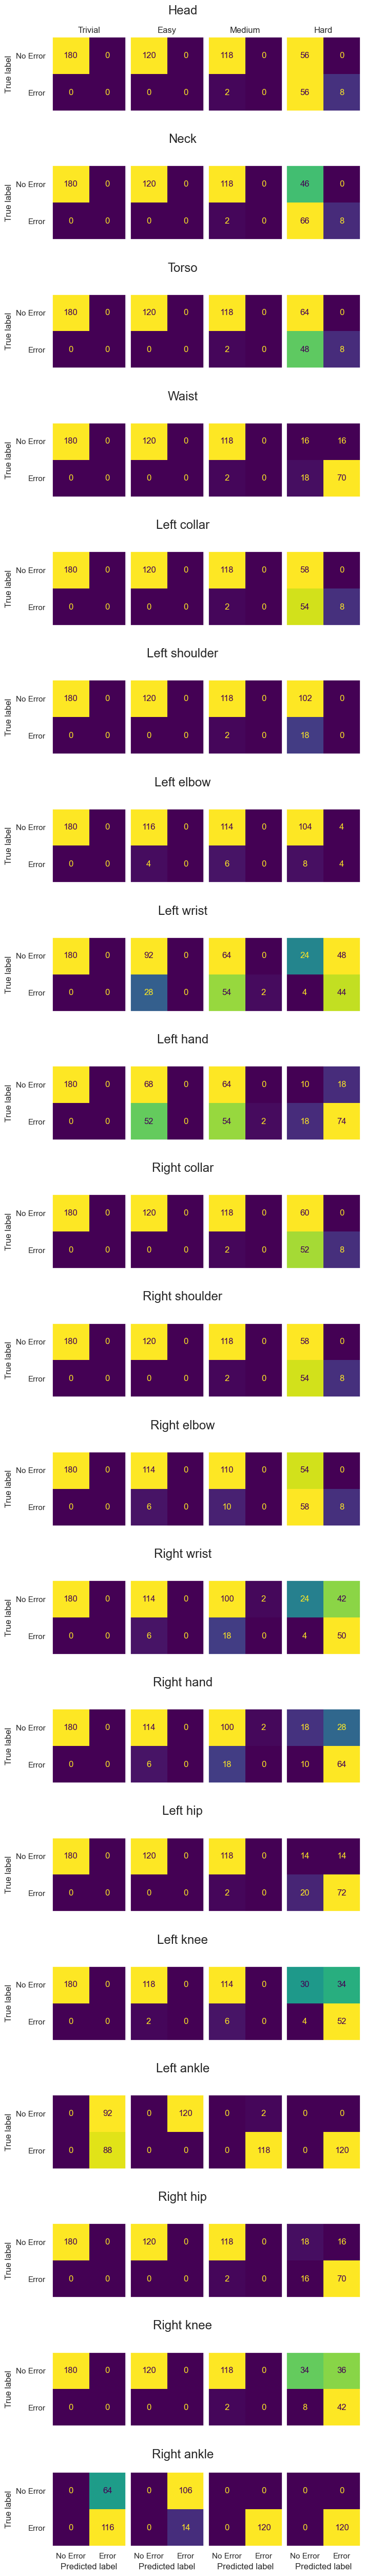

In [37]:
figure = plt.figure(layout='constrained', figsize=(7, 2.5 * len(joint_names)))
subfigs = figure.subfigures(len(joint_names), 1)

difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for i, joint_name in enumerate(joint_names):
  axs = subfigs[i].subplots(1, 4, sharey=True)
  subfigs[i].suptitle(joint_name, fontsize='x-large')
  for difficulty in [0, 1, 2, 3]:  
    crit_1 = df_model_joints_test["difficulty"] == difficulty
    crit_2 = df_model_joints_test["joint_names"] == joint_name
    crit = crit_1 & crit_2
    gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_joints_test[crit]["gts"].values.tolist()]
    preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_joints_test[crit]["preds"].values.tolist()]

    cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
    disp.plot(ax=axs[difficulty], colorbar=False)

    axs[difficulty].grid(False)
    if i == 0:
      axs[difficulty].set_title(difficulty_names[difficulty])
    if i < len(joint_names) - 1:
      axs[difficulty].set_xlabel("") 
      axs[difficulty].set_xticks([]) 
    if difficulty != 0:
      axs[difficulty].set_ylabel("")

#plt.tight_layout()
plt.savefig("figures/confusion/joints.png")
plt.show()